In [1]:
import dpkt
import os
import struct
import numpy as np
from collections import defaultdict
from pprint import pprint

try:
    from Memoizer import memoize_to_folder
    memoize = memoize_to_folder("e2e_memoization")
except:
    # In case Memoizer isn't present, this decorator will just do nothing
    print("Warning: Unable to import memoizer")
    memoize = lambda x : x


In [2]:
from scapy.all import *

K = 5
H = 1

def blk_cls_idx(fec,):
    blk_cls_idx, = struct.unpack("!H", fec[:2])
    blk = (blk_cls_idx >> 8) & 0b00011111
    cls = ((blk_cls_idx >> 8) & 0b11100000) >> 5
    idx = blk_cls_idx & 0x0F
    
    pkt_len, = struct.unpack("H", fec[4:6])
    return blk, cls, idx, pkt_len

@memoize
def get_latencies(out_dir,
                  encoded_input = False,
                  encoded_output = False,
                  dst_mac_is_ts = True, 
                  compare_counters = True,
                  expected_class = 0):
    
    pcf = os.path.join(out_dir, 'moongen', 'moongen.pcap')
    
    ts_in = []
    ts_out = []    

    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    
    last_blk_idx = [None, -1]
    block_buffer = []
    
    n_discarded_buffer = 0
    n_discarded_unknown = 0
    
    def handle_block_buffer(fec, ts, ts_buff):        
        nonlocal n_discarded_unknown, n_discarded_buffer, block_buffer, last_blk_idx
        
        blk, cls, idx, pkt_len = blk_cls_idx(fec)
#         print(blk,cls,idx)
        
        if (cls != expected_class):
            IP(fec).show()
            n_discarded_unknown += 1
            return

        if last_blk_idx[0] is not None and \
                last_blk_idx[0] != blk or \
                last_blk_idx[1] >= idx:
            if len(block_buffer) != K:
                raise Exception("Unfinished block with %d entries" % len(block_buffer))
            ts_buff.extend(block_buffer)
            block_buffer = []
 
        last_blk_idx[0] = blk
        last_blk_idx[1] = idx
        
        if len(block_buffer) >= K:
            n_discarded_buffer += 1
            return

        block_buffer.append(ts)  
        
    skipped = 0
    tss = []
    for i, (ts, buf) in enumerate(pcap):
        try:
            eth=dpkt.ethernet.Ethernet(buf)
            fec = eth.data

        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            Ether(buf).show2()
            raise

        if dst_mac_is_ts:
            x3, x2, x1 = struct.unpack("!HHH", eth.dst)
            ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
            
        ### Assumes src mac is origin
        x3, x2, x1 = struct.unpack("!HHH", eth.src)
        
        if x1 == 1:                
            if encoded_output:
                try:
                    try_ip = dpkt.ip.IP(fec)
                    if try_ip.proto == 17 and try_ip.src == '0.0.0.0' and try_ip.dst == '255.255.255.255':
                        skipped+=1
                        print(skipped)
                        continue
                except:
                    pass
                handle_block_buffer(fec, ts, ts_out)
            else:
                ts_out.append(ts)
                
        elif x1 == 2:
            if encoded_input:
                handle_block_buffer(fec, ts, ts_in)
            else:
                ts_in.append(ts)
                
    print("Finished reading pcap: %d total packets \n"
          "Skipped %d packets due to broadcast UDP\n"
          "Discarded %d packets due to buffering \n" 
          "Discarded %d packets due to incorrect FEC class\n"
          "Got %d input and %d output packets"%
          (i, skipped, n_discarded_buffer, n_discarded_unknown, len(ts_in), len(ts_out)))
    
#     if len(block_buffer) != K and len(block_buffer) != 0:
#         raise Exception("Unfinished block at end with %d entries" % len(block_buffer))
        
    if encoded_input:
        ts_in.extend(block_buffer)
    elif encoded_output:
        ts_out.extend(block_buffer)
        
#     ts_in = ts_in[:len(ts_out)]
        
    if len(ts_in) != len(ts_out):
        raise Exception("Received %d input packets and %d output packets" %
                        (len(ts_in), len(ts_out)))
    
    print("Calculated %d latencies" % len(ts_out))
    
    return np.array(ts_in), np.array(ts_out) - np.array(ts_in)

In [8]:

EXP = '/home/ncshy/P4Boosters/testing/fec/execution/test_output/fpga_fec_decoder/fpga_fec_decoder_100.00/'

latencies = get_latencies(EXP, encoded_input=True, expected_class=0)
tot = 0
count = 0
for val in latencies[1]:
    tot += val
    count += 1

avg = tot/count   
print((avg, tot, count))
print("Calculated avg latency" % (avg))

Reading /home/ncshy/P4Boosters/testing/fec/execution/test_output/fpga_fec_decoder/fpga_fec_decoder_100.00/moongen/moongen.pcap
###[ IP ]### 
  version   = 6
  ihl       = 0
  tos       = 0x0
  len       = 0
  id        = 36
  flags     = 
  frag      = 1
  ttl       = 254
  proto     = 128
  chksum    = 0x72d0
  src       = 0.0.0.0
  dst       = 38.138.7.255
  \options   \
   |###[ IP Option ]### 
   |  copy_flag = 1
   |  optclass  = 3
   |  option    = rfc4727_experiment
   |  length    = 91
   |  value     = '\x155\xff\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x16:\x00\x05\x02\x00\x00\x01\x00\x8f\x00\x19_\x00\x00\x00\x01'
###[ Padding ]### 
     load      = '\x04\x00\x00\x00\xff\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\xff[\x155'

###[ IP ]### 
  version   = 6
  ihl       = 0
  tos       = 0x0
  len       = 0
  id        = 36
  flags     = 
  frag      = 1
  ttl       = 254
  proto     = 128
  chksum    = 0x72d0
  src       = 0.0.0.0
  dst       = 38.138.7.255
  \op

Exception: Unfinished block with 1 entries

<IPython.core.display.Javascript object>


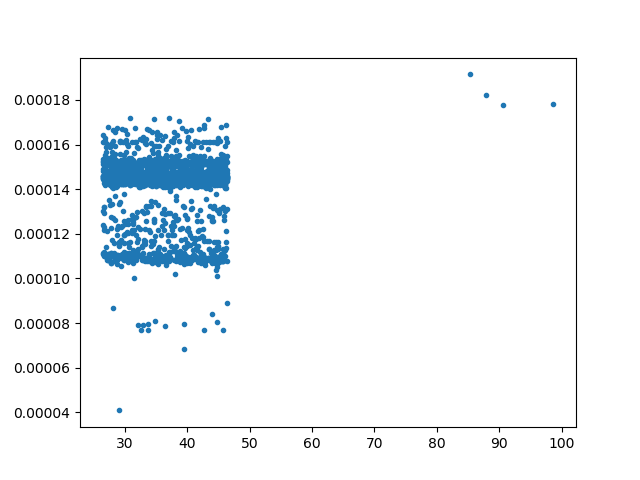

In [31]:
plt.figure()
plt.plot(latencies[0], latencies[1], '.')

In [16]:
pcf = os.path.join(EXP, 'moongen', 'moongen.pcap')
pcap=dpkt.pcap.Reader(open(pcf, 'rb'))

In [17]:
for i, (ts, pkt) in enumerate(pcap):
    print(pkt)
    if i > 10:
        break

b'\x00\x03\xee\xb3\xce\\\x00\x00\x00\x00\x00\x02\x124E\x00\x01\x11\x11\x11\x00\x00\x11=\x93\x9c\x01\x01\x01\x01\x01\x01\x01\x01\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11'
b'\x00\x03\xee\xb3\xe0;\x00\x00\x00\x00\x00\x01\x124\x00\x00\x08\x00\x04\x10E\x00\x01\x11\x08\x04\x00\x00\x11=\x93\x9c\x01\x01\x01\x01\x01\x01\x01\x01\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11'
b'\x00\x03\xee\xb4\xf6\xf2\x00\x00\x00\x00\x00\x02\x124E\x00\x01\x11""\x00\x00"=m\x87\x02\x02\x02\x02\x02\x02\x02\x02"""""""""""""""""""""""""""""""""""""""""""""""""""""""""'
b'\x00\x03\xee\xb5\x08\xd8\x00\x00\x00\x00\x00\x01\x124\x00\x01\x08\x00\x04\x10E\x00\x01\x11\x1c\x17\x00\x00"=m

<IPython.core.display.Javascript object>


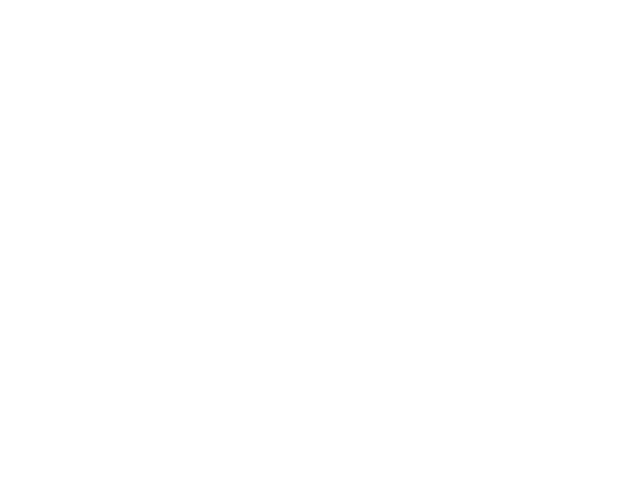

TypeError: can't multiply sequence by non-int of type 'float'

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
x = plt.hist(latencies * 1e6, 100)
plt.xlabel("Latencies (µS)")
plt.ylabel("N Pkts")
plt.yscale('log')

<IPython.core.display.Javascript object>


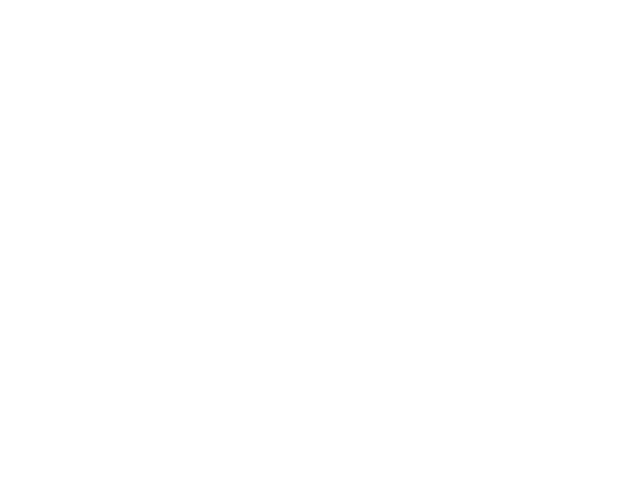

TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
plt.figure()
plt.plot(latencies * 1e6,'.')